In [1]:
import pandas as pd
from pydantic import BaseModel, ConfigDict
import numpy as np
import numpy.typing as npt
from typing import Any, Callable
import matplotlib.pyplot as plt
from dataclasses import dataclass
from scipy.signal import spectrogram, convolve, ShortTimeFFT, windows
from scipy.fftpack import fftshift

from sklearn.preprocessing import StandardScaler

from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn.functional as tfunc

from os import PathLike
from functools import partial
from typing import Self

from scipy import signal

In [2]:
if torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
    print("-"*80)
    print("using mps device")
    print("-"*80)

else: 
    DEVICE = torch.device('cpu')
    print("no mps available falling back to cpu")


--------------------------------------------------------------------------------
using mps device
--------------------------------------------------------------------------------


In [3]:
class LineSchema(BaseModel):
    model_config = ConfigDict(arbitrary_types_allowed=True)
    id: int
    event: int
    device: Any
    channel: Any
    code: int
    size: int
    # code_one_hot: torch.Tensor
    data: npt.NDArray

    @classmethod
    def from_raw_line(cls, line:str, tensor_device=None ):
        values = line.split()
        
        id = values[0]
        event= values[1]
        device= values[2]
        channel= values[3]
        code= values[4]
        size=values[5]
        
        # code_one_hot = nn.functional.one_hot(torch.tensor(int(values[4])), num_classes=10)
        data=(np.fromstring(values[6], sep = ",", dtype=np.float32))

        # code_one_hot = code_one_hot.to(device = tensor_device)
        # data = data.to(device = tensor_device)

        return cls(id=id,event=event,device=device,channel=channel,code=code,size=size,data=data)
    
    def ouput_transforms(self, output_size):
        # odd_adj =  self.data.shape[0] % 2

        # pad_dim = (output_size - self.data.shape[0])//2 

        # return np.pad(self.data/np.linalg.norm(self.data), pad_width=(pad_dim, pad_dim+odd_adj))

        BANDSTOP_FREQ = 40
        fft = np.fft.rfft(self.data)
        freqs = np.fft.rfftfreq(len(self.data), (2/len(self.data)))
        
        bandstop_fft = fft
        bandstop_fft[freqs > BANDSTOP_FREQ] = 0

        out_signal = np.fft.irfft(bandstop_fft)

        out_signal = signal.resample(out_signal, output_size)

        out_signal = np.fft.rfft(out_signal)
        out_signal = np.abs(out_signal[1:])
        return out_signal
        


In [4]:
# def from_txt_file(cls, filepath: PathLike, device=None, transform=None):
parsed_lines = []
with open("MU.txt") as f:
    max_len = 0
    for line in f:

        parsed_line = LineSchema.from_raw_line(line)

        parsed_lines.append(parsed_line)


df  = pd.DataFrame([k.model_dump(exclude = "data") for k in parsed_lines])

In [5]:
df[df["code"] == 2]

,id,event,device,channel,code,size
56,978167,132683,MU,TP9,2,476
57,978168,132683,MU,FP1,2,476
58,978169,132683,MU,FP2,2,476
59,978170,132683,MU,TP10,2,476
84,978195,132690,MU,TP9,2,459
...,...,...,...,...,...,...
119379,1097490,162513,MU,TP10,2,459
119432,1097543,162527,MU,TP9,2,476
119433,1097544,162527,MU,FP1,2,476
119434,1097545,162527,MU,FP2,2,476


In [187]:
idx = np.random.randint(0, len(parsed_lines))
record = (parsed_lines[999])
print(record.data.shape[-1]/2)

length = record.data.shape[-1]
# T_x, N = length/2, length 
# t_x = np.arange(N) * T_x
WIN = 64
w = windows.tukey(WIN, alpha = 0.25, sym=True) 
SFT = ShortTimeFFT(win = w,hop = WIN//8,fs=length/2)

t0, t1, f0, f1 = SFT.extent(length)

t = SFT.t(length)

# SFT.f
# spec = SFT.spectrogram(record.data,) 

stft = SFT.stft(record.data)

# print(f"{Sxx.shape = }")
# print(f"{t.shape = }")
# print(f"{f.shape = }")

229.5


TypeError: Dimensions of C (65, 37) are incompatible with X (65) and/or Y (33); see help(pcolormesh)

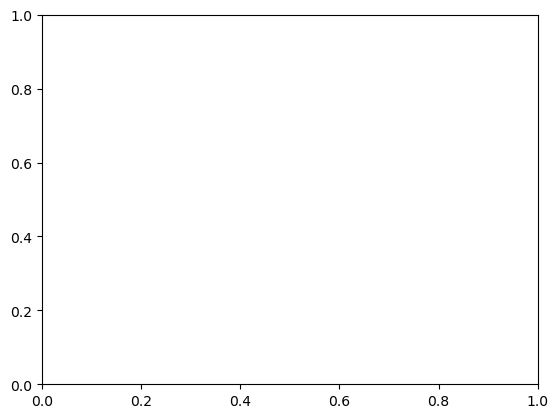

In [188]:
plt.pcolormesh(t, fftshift(SFT.f), fftshift(abs(spec), axes=0), shading = 'gouraud')

In [190]:
f, t, Sxx = spectrogram(record.data, fs = length/2, nperseg=(win:=8), noverlap=win//8, return_onesided=False)

# print(f"{Sxx.shape = }")
# print(f"{t.shape = }")

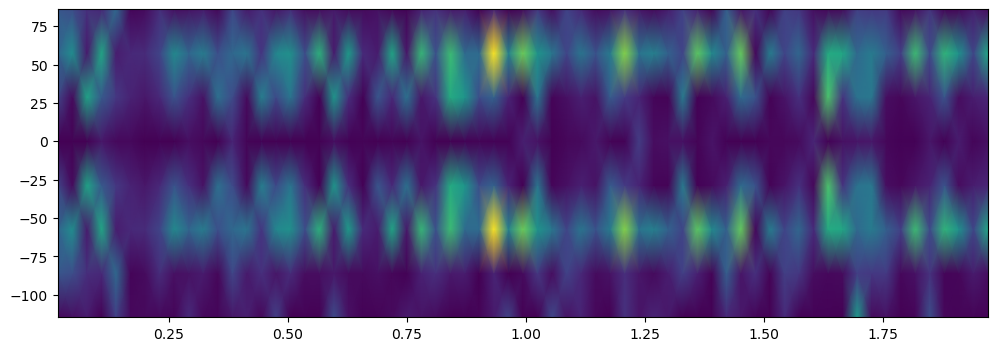

In [191]:

plt.subplots(figsize = (12,4))
plt.pcolormesh(t, fftshift(f), fftshift((Sxx), axes=0), shading = 'gouraud')



Label  = 2
orig_signal.shape = (476,)
orig_signal.shape = (476,)
orig_signal.shape = (476,)
orig_signal.shape = (476,)
Label  = 2
(476,)
[ 3.06952941e+05+0.00000000e+00j  1.71152412e+03-4.32828722e+03j
  4.37260435e+01+8.81109795e+01j  1.27430643e+02-1.89752970e+03j
 -7.24781437e+02-3.11910915e+02j  3.77593562e+02-4.38497058e+02j
 -3.57824639e+02-5.13642235e+01j  2.97657792e+02-2.42333468e+02j
 -2.12259041e+02-7.09459245e+02j  4.66810651e+02-2.86791497e+00j
 -2.91498875e+02-4.28074557e+02j  2.54767303e+02+3.48564013e+01j
 -2.74966219e+01-3.19584511e+02j  1.80929212e+02-2.73132983e+02j
 -8.27073651e+01-4.38630902e+02j  1.35215435e+00+2.30373012e+01j
  1.02280676e+01-4.74677830e+02j -8.51604363e+01+7.37102648e+01j
  2.06717706e+01+5.06658820e+01j -1.81702346e+02-8.72692537e+01j
  1.82170490e+02-2.03028585e+02j -1.06795526e+02-3.01684787e+02j
  4.01300784e+01+3.36438453e+01j -1.42336889e+02-1.17454971e+02j
  1.80083947e+02-3.90180250e+01j -6.73641460e+01-2.19124144e+02j
  4.21616557e+01-6

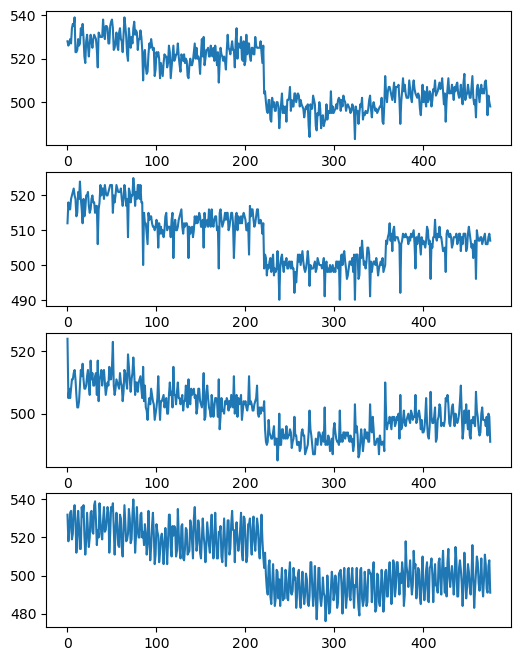

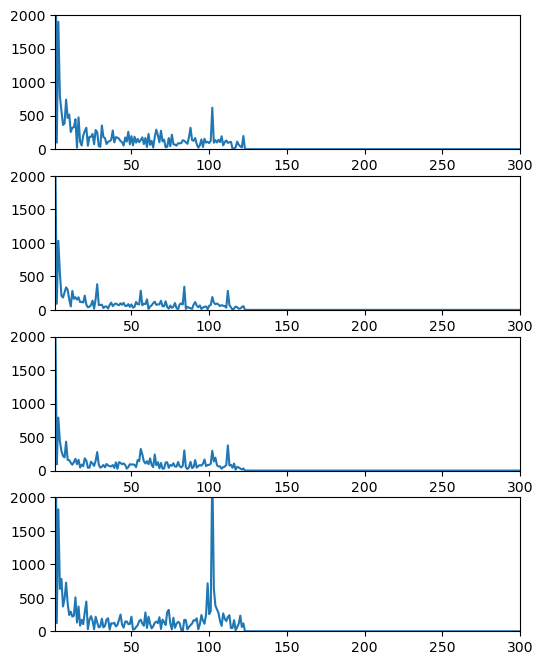

In [1296]:
plt_data = df[df["event"]==162527]


fix,axes = plt.subplots(4, 1, figsize = (6, 8))
print(f"Label  = {plt_data['code'].iloc[0]}")

for idx, ax in enumerate(axes):
    orig_signal = plt_data["data"].iloc[idx]
    print(f"{orig_signal.shape = }")
    ax.plot(orig_signal)

fix,axes = plt.subplots(4, 1, figsize = (6, 8))
print(f"Label  = {plt_data['code'].iloc[0]}")

previous = None
for idx, ax in enumerate(axes):
    arr = plt_data["data"].iloc[idx]
    # print(arr.shape)
    fft = np.fft.rfft(arr)
    freqs = np.fft.rfftfreq(len(arr), (2/len(arr)))
    # print(freqs)
    # print()
    bandstop_fft = fft
    bandstop_fft[freqs > 61] = 0
    new_signal = np.fft.irfft(bandstop_fft)
    print(new_signal.shape)
    new_signal = signal.resample(new_signal, 600)
    new_signal = np.fft.rfft(new_signal)
    # if previous is not None:
    ax.plot(np.abs(new_signal))
    # previous = new_signal

    # ax.axvline(64, color = "r")
    # ax.axvline(64+64, color = "r")

    

    ax.set_xlim([1,300])
    ax.set_ylim([0,2000])

    print(new_signal)

In [742]:
df["event"].unique()

array([132669, 132670, 132671, ..., 173649, 173650, 173651])

In [560]:
events = df["event"].unique()



In [575]:
df[df["event"] == events[10]]

,id,event,device,channel,code,size,data
40,978151,132679,MU,TP9,3,459,"[506.0, 505.0, 518.0, 512.0, 511.0, 503.0, 508..."
41,978152,132679,MU,FP1,3,459,"[501.0, 511.0, 511.0, 510.0, 505.0, 507.0, 508..."
42,978153,132679,MU,FP2,3,459,"[508.0, 503.0, 497.0, 501.0, 492.0, 497.0, 504..."
43,978154,132679,MU,TP10,3,459,"[509.0, 498.0, 503.0, 508.0, 508.0, 499.0, 493..."


In [ ]:
np.pad()

In [348]:
def pad_data(row: torch.Tensor, pad_len:int):

    #adjustment to make pad length equal for even or odd shapes since floor (//) is -1 in odd case
    odd_adj =  row.shape[0] % 2

    pad_dims = (pad_len - row.shape[0])//2 

    return tfunc.pad(tfunc.normalize(row, dim=0), pad=(pad_dims, pad_dims+odd_adj))

In [1299]:
class CustomEEGDataset(Dataset):
    def __init__(
        self,  event_data: list[torch.Tensor],labels:list[torch.Tensor], max_len=None
    ) -> None:
        # self.metadata = metadata
        self.event_data = event_data
        self.labels = labels
        # self.transform = transform
        self.max_len = max_len

    @classmethod
    def from_txt_file(cls, filepath: PathLike, device=None, transform=None):
        parsed_lines: list[LineSchema] = []
        with open(filepath) as f:

            for idx, line in enumerate(f):
                
                parsed_line = LineSchema.from_raw_line(line, tensor_device=device)
                
                parsed_lines.append(parsed_line)
        
        df_metadata  = pd.DataFrame([k.model_dump(exclude = "data") for k in parsed_lines])
        max_len = df_metadata["size"].max()
        data_array = np.array([k.ouput_transforms(max_len) for k in parsed_lines])
        events = df_metadata["event"].unique()

        event_data = []
        labels = []
        for event in events:
            event_meta = df_metadata[df_metadata["event"]== event]
            label = event_meta["code"].drop_duplicates().item()
            if label == -1:
                continue
            label_encoded = nn.functional.one_hot(torch.tensor(label, device=device), num_classes=10)
            labels.append(label_encoded)
            event_array = torch.tensor(data_array[event_meta.index], dtype = torch.float32, device = device)
            # event_array = tfunc.normalize(event_array, dim = 1)
            event_array = (event_array - event_array.mean())/event_array.std()
            event_data.append(event_array)

        return cls(
            event_data,labels,  max_len=max_len
        )

    def __getitem__(self, index) -> Any:
        signal = self.event_data[index]
        label = self.labels[index]
     
        return signal, label

    def __len__(self):
        return len(self.event_data)

    @classmethod
    def split(cls, other_cls: Self, prop=0.25, seed=1, sampling = 1.0) -> tuple[Self, Self]:
        rng = np.random.default_rng(seed)
        idxes = np.arange(0, len(other_cls), 1)
        rng.shuffle(idxes)
        new_len = int(round(len(other_cls)*sampling))
        
        idxes = idxes[0:new_len]

        num_test = round(new_len * prop)

        # df_metadata = other_cls.metadata
        event_data = other_cls.event_data
        labels = other_cls.labels

        test_event_data = [event_data[i] for i in idxes[0:num_test]]
        test_labels = [labels[i] for i in idxes[0:num_test]]

        
        train_event_data = [event_data[i] for i in idxes[num_test:]]
        train_labels = [labels[i] for i in idxes[num_test:]]

        return cls(
            train_event_data,train_labels,  max_len=other_cls.max_len
        ), cls(test_event_data,test_labels, max_len=other_cls.max_len)

In [1308]:
class EEGModel(nn.Module):

    def __init__(self, ) -> None:
        super().__init__()
        self.lconv1 = nn.Conv1d(4,32, 32)
        # self.lconv2 = nn.Conv1d(32,8, 8)
        # self.lconv3 = nn.Conv1d(8,8, 8)
        self.lconv4 = nn.Conv1d(32,64, 8)
        
        self.rconv1 = nn.Conv1d(4,32, 4)
        # self.rconv2 = nn.Conv1d(32,8, 4)
        # self.rconv3 = nn.Conv1d(8,8, 4)
        self.rconv4 = nn.Conv1d(32,64, 4)


        self.pool1 = nn.MaxPool1d(16)
        self.pool2 = nn.MaxPool1d(8)
        self.pool3 = nn.MaxPool1d(8)


        
        # nn.Conv1d(4,6, 16)
        self.drop = nn.Dropout(p = 0.2)
        self.flat = nn.Flatten()
        self.lin1 = nn.Linear(256,512)
        self.lin2 = nn.Linear(512,64)
        # self.lin3 = nn.Linear(512,512)
        # self.lin4 = nn.Linear(256,256)
        # self.lin3 = nn.Linear(256,256)
        # self.lin5= nn.Linear(256,64)

        self.lin6  = nn.Linear(64, 10)
        
        self.rel = nn.ReLU()
    
    def forward(self, x: torch.Tensor):
        # print(x)
        x1 = self.pool2(self.rel(self.lconv1(x)))
        x1 = self.drop(x1)
        # x1 = (self.rel(self.lconv2(x1)))
        
        # x1 = (self.rel(self.lconv3(x1)))

        x1 = self.pool3(self.rel(self.lconv4(x1)))

        x2 = self.pool1(self.rel(self.rconv1(x)))
        x2 = self.drop(x2)
        # x2 = (self.rel(self.rconv2(x2)))
        # x2 = (self.rel(self.rconv3(x2)))
        x2 = self.pool2(self.rel(self.rconv4(x2)))

        
        x1 = self.flat(x1)
        x2 = self.flat(x2)

        # print(f"{x1.shape = }")
        # print(f"{x2.shape = }")

        x = torch.cat((x1, x2), dim = 1)
        # print(x)

        x = self.drop(x)

        x = self.flat(x)
        x = self.rel(self.lin1(x))
        x = self.rel(self.lin2(x))
        # x = self.rel(self.lin3(x))
        # x = self.rel(self.lin4(x))
        # x = self.rel(self.lin5(x))
        # x = self.drop(x)


        logits = self.lin6(x)

        return logits
    

In [1301]:


def train_loop(dataloader: DataLoader, model: nn.Module, loss_fn: torch.nn.CrossEntropyLoss, optimizer: torch.optim.Optimizer, batch_size: int):
    
    size = len(dataloader.dataset)

    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        # print(X.unsqueeze(0).shape)

        pred = model(X.float())
        loss = loss_fn(pred, y.float())
        # print(pred[0])
        # print(y[0])

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader:DataLoader, model: nn.Module, loss_fn: torch.nn.CrossEntropyLoss):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            pred = model(X.float())
            
            test_loss += loss_fn(pred, y.float()).item()

            correct += (pred.argmax(axis = 1) == y.argmax(axis = 1)).type(torch.float).sum().item()

            # print(pred)
            

    print(f"{batch= }")
    print(f"{size = }")
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return 100*correct, test_loss

In [1302]:
data_set = CustomEEGDataset.from_txt_file("MU.txt", device = DEVICE, transform=pad_data)

In [1303]:
train_ds, test_ds = CustomEEGDataset.split(data_set, sampling=0.5)

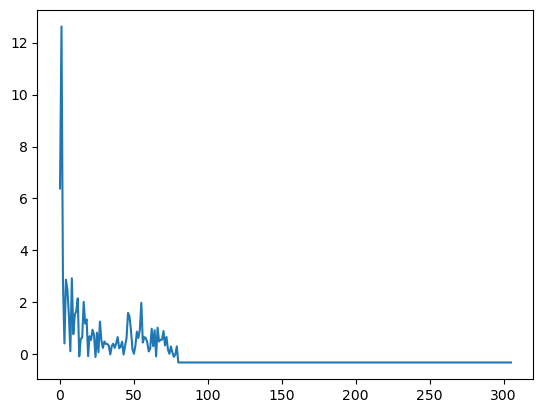

In [1304]:
c = nn.Conv1d(4, 8, 16, device= DEVICE)
f = nn.MaxPool1d(4)
data = data_set[56][0][0]

p = data
# data[0]
# p = (c(data))
# print(p.shape)
plt.plot(p.cpu().detach().numpy())


In [1309]:
BATCH_SIZE = 32
train_data = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_data = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)


In [1310]:
learning_rate = 0.001
batch_size = BATCH_SIZE
# epochs = 1

model = EEGModel().to(DEVICE)
print(model)
# model

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, eps = 1e-8)
loss_fn = nn.CrossEntropyLoss()

EEGModel(
  (lconv1): Conv1d(4, 32, kernel_size=(32,), stride=(1,))
  (lconv4): Conv1d(32, 64, kernel_size=(8,), stride=(1,))
  (rconv1): Conv1d(4, 32, kernel_size=(4,), stride=(1,))
  (rconv4): Conv1d(32, 64, kernel_size=(4,), stride=(1,))
  (pool1): MaxPool1d(kernel_size=16, stride=16, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool1d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool1d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.2, inplace=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (lin1): Linear(in_features=256, out_features=512, bias=True)
  (lin2): Linear(in_features=512, out_features=64, bias=True)
  (lin6): Linear(in_features=64, out_features=10, bias=True)
  (rel): ReLU()
)


In [1311]:
# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 5
metrics = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_data, model, loss_fn, optimizer, batch_size=BATCH_SIZE)
    accuracy, test_loss  = test_loop(test_data, model, loss_fn)
    metrics.append({"epoch": t, "accuracy":accuracy, "test_loss":test_loss})
print("Done!")

df_metrics = pd.DataFrame.from_records(metrics)
df_metrics.to_csv("test_metrics.csv")

Epoch 1
-------------------------------
loss: 2.333914  [   32/11205]
loss: 2.299724  [ 3232/11205]
loss: 2.288584  [ 6432/11205]
loss: 2.309002  [ 9632/11205]
batch= 116
size = 3735
Test Error: 
 Accuracy: 9.4%, Avg loss: 2.302883 

Epoch 2
-------------------------------
loss: 2.307261  [   32/11205]
loss: 2.306257  [ 3232/11205]
loss: 2.305504  [ 6432/11205]
loss: 2.301832  [ 9632/11205]
batch= 116
size = 3735
Test Error: 
 Accuracy: 9.6%, Avg loss: 2.303454 

Epoch 3
-------------------------------
loss: 2.301095  [   32/11205]
loss: 2.301137  [ 3232/11205]
loss: 2.317154  [ 6432/11205]
loss: 2.295530  [ 9632/11205]
batch= 116
size = 3735
Test Error: 
 Accuracy: 10.8%, Avg loss: 2.303312 

Epoch 4
-------------------------------
loss: 2.301291  [   32/11205]
loss: 2.299315  [ 3232/11205]
loss: 2.293309  [ 6432/11205]
loss: 2.293255  [ 9632/11205]
batch= 116
size = 3735
Test Error: 
 Accuracy: 10.1%, Avg loss: 2.303175 

Epoch 5
-------------------------------
loss: 2.308311  [   32

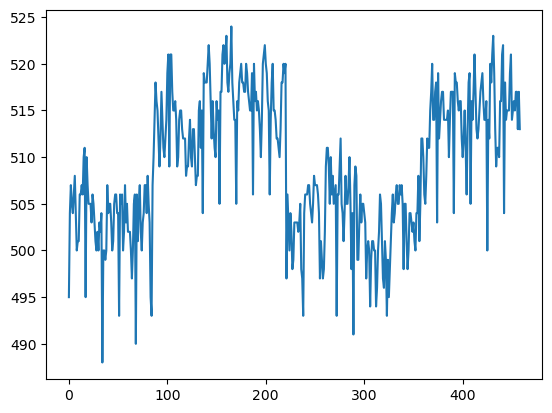

In [1075]:
plt.plot((parsed_lines[12000].data), marker = "", linestyle = "-")

In [1334]:
idx = np.random.randint(0, len(parsed_lines))

record = (parsed_lines[idx])

f, t, Sxx = spectrogram(record.data, fs =(2/record.size)**(-1), nperseg=16)

print(f"{Sxx.shape = }")
print(f"{t.shape = }")
print(f"{f.shape = }")

Sxx.shape = (9, 32)
t.shape = (32,)
f.shape = (9,)


In [1335]:

Sxx

array([[7.24637648e-04, 8.87681171e-03, 2.46578100e-04, 1.45430758e-03,
        1.45430758e-03, 5.15297893e-03, 2.32689213e-02, 1.25805149e-02,
        8.05152953e-03, 2.34782606e-01, 7.65398517e-03, 8.05152958e-05,
        4.83594975e-03, 3.66847822e-03, 4.83594975e-03, 5.81723033e-03,
        1.81662641e-03, 6.08896953e-04, 2.66203703e-03, 6.52173907e-03,
        1.81159412e-04, 5.48007246e-03, 6.08896953e-04, 5.81723033e-03,
        6.08896953e-04, 6.16445253e-03, 2.01288240e-05, 1.81159412e-04,
        2.98359487e-02, 6.52173907e-03, 7.24637648e-04, 2.06119157e-02],
       [1.00258067e-01, 6.18049204e-01, 1.19439311e-01, 3.16210032e-01,
        2.95640558e-01, 9.65554833e-01, 9.72033381e-01, 2.61228234e-01,
        2.59716868e-01, 3.46188009e-01, 5.41155823e-02, 8.31329748e-02,
        3.07260044e-02, 9.04178992e-02, 2.12219614e-03, 1.44173130e-01,
        2.55365223e-01, 1.11542426e-01, 8.50318253e-01, 6.39617741e-02,
        3.31374705e-02, 6.48567872e-03, 1.09645156e-02, 2.41254

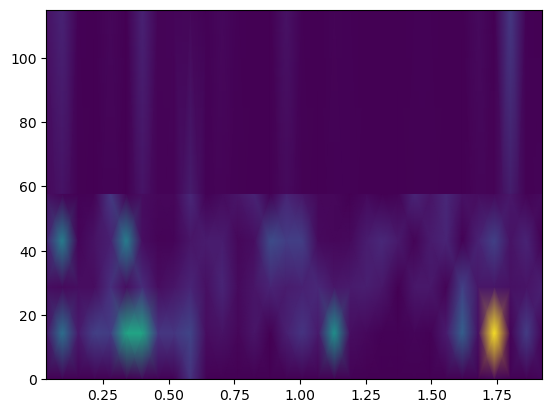

In [1336]:
plt.pcolormesh(t, fftshift(f), fftshift(Sxx, axes =0), shading = 'gouraud')